In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
%matplotlib notebook
pd.options.display.max_rows = None
pd.options.display.max_columns = None


In [2]:
df_melhores = pd.read_feather('dados/melhores.feather')
df_turmas = pd.read_feather('dados/turmas2018.feather')
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')

Inventando meu cálculo de nota final. Para mim redação tem peso 2




In [24]:
df_enem_rio['nota_final'] = df_enem_rio\
  .loc[:, ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 
           'NU_NOTA_REDACAO', 'NU_NOTA_REDACAO']]\
  .mean(axis=1)

In [45]:
df_melhores = df_enem_rio.loc[:, [ 'CO_ESCOLA','nota_final']].groupby('CO_ESCOLA')\
       .agg(mediana=('nota_final','median'), num=('nota_final','count'))\
       .sort_values('mediana', ascending=False)
df_melhores = df_melhores[df_melhores.num > 30]
df_melhores

,mediana,num
CO_ESCOLA,,
33062633,770.566667,62
33135371,763.233333,91
33063729,754.641667,246
33176825,753.900000,185
33065403,750.016667,135
33142726,745.866667,35
33148376,742.941667,74
33135827,741.883333,94
33104220,741.650000,69


In [3]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648

In [34]:
#df_melhores = df_melhores[:50]
#df_melhores['CO_ESCOLA'] = df_melhores.CO_ESCOLA.astype('category')

In [46]:
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False)

In [47]:
df_melhores.merge(df_escolas, left_index=True, right_on='CO_ENTIDADE').loc[:,
    ['NO_ENTIDADE',  'mediana', 'num', 'rank']]

,NO_ENTIDADE,mediana,num,rank
177267,COL DE SAO BENTO,770.566667,62,1.0
189289,COLEGIO CRUZEIRO - JACAREPAGUA,763.233333,91,2.0
177286,COLEGIO SANTO INACIO,754.641667,246,3.0
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,753.900000,185,4.0
175263,COLEGIO SANTO AGOSTINHO,750.016667,135,5.0
190825,COL ISRAELITA BRAS A LIESSIN SCHOLEM ALEICHEM,745.866667,35,6.0
188313,ESCOLA PARQUE - BARRA,742.941667,74,7.0
191289,COLEGIO E CURSO PENSI,741.883333,94,8.0
190474,RECANTO INF IMACULADA CONCEICAO,741.650000,69,9.0
194555,COLEGIO DE A A Z - UNIDADE TIJUCA,739.166667,63,10.5


In [43]:
df_melhores.head(50)

,NO_ENTIDADE,mediana,num,rank


,CO_ESCOLA,NO_ENTIDADE,rank
0,33135371,COLEGIO CRUZEIRO - JACAREPAGUA,1.0
1,33176825,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,4.5
2,33173869,COLEGIO DE A A Z UNIDADE RECREIO,4.5
3,33148376,ESCOLA PARQUE - BARRA,4.5
4,33063729,COLEGIO SANTO INACIO,4.5
5,33062633,COL DE SAO BENTO,4.5
6,33085897,ESC MODELAR CAMBAUBA,4.5
7,33104220,RECANTO INF IMACULADA CONCEICAO,11.5
8,33322201,ESCOLA SESC DE ENSINO MEDIO,11.5
9,33135827,COLEGIO E CURSO PENSI,11.5


In [8]:
df_enem = df_enem_rio.merge(df_melhores, on="CO_ESCOLA")
df_enem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4436 entries, 0 to 4435
Columns: 140 entries, index to rank
dtypes: float64(30), int32(1), int64(65), object(44)
memory usage: 4.8+ MB


In [9]:
my_order = df_enem.groupby(by=["NO_ENTIDADE"])["NU_NOTA_REDACAO"].median().iloc[::-1].index

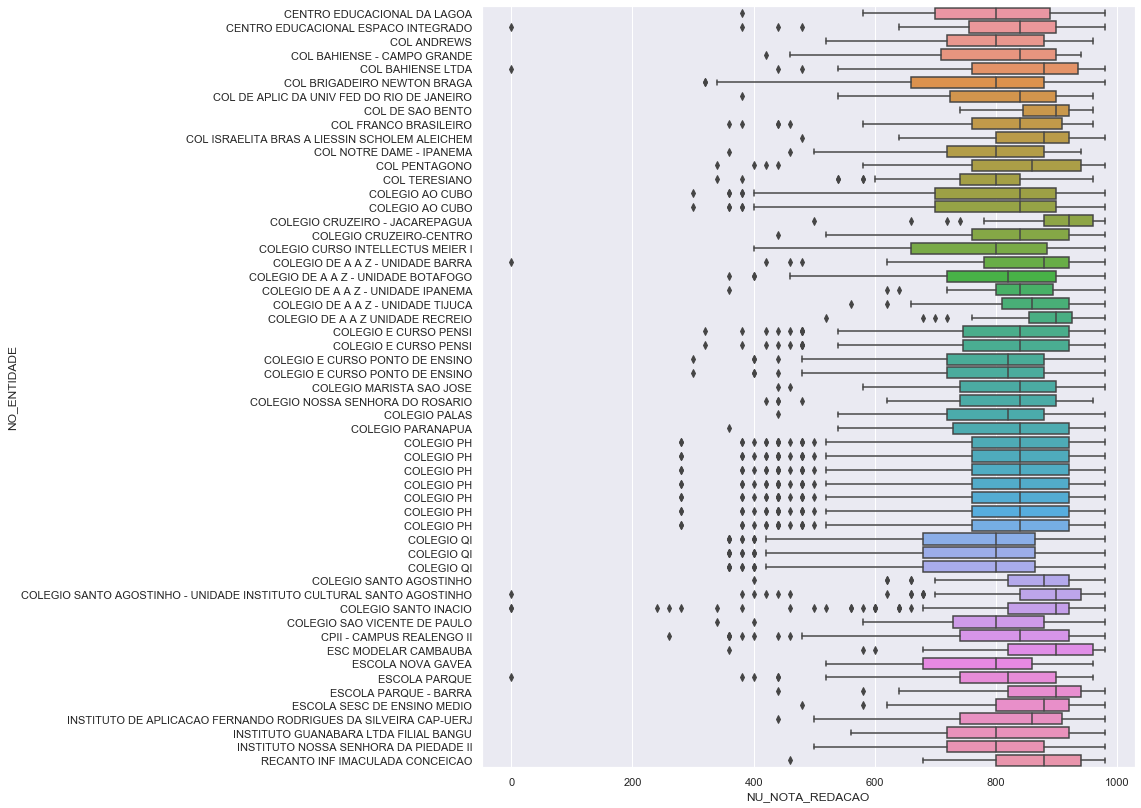

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,14)})
sns.boxplot(data=df_enem, y='NO_ENTIDADE', x='NU_NOTA_REDACAO', orient='h', order=df_melhores.NO_ENTIDADE.sort_values());

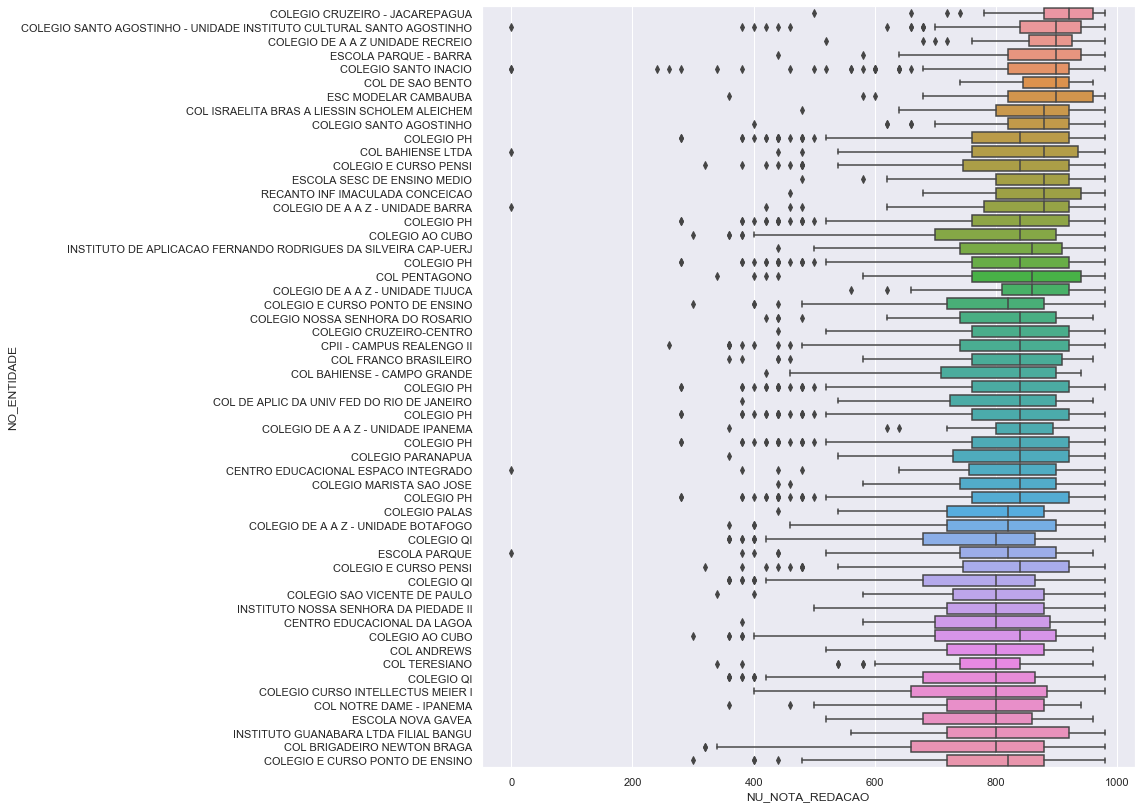

In [11]:
sns.boxplot(data=df_enem, y='NO_ENTIDADE', x='NU_NOTA_REDACAO', orient='h', order=df_melhores.sort_values('rank')['NO_ENTIDADE']);

In [12]:
df_escolas.columns.tolist()

['CO_ENTIDADE',
 'NU_ANO_CENSO',
 'NO_ENTIDADE',
 'CO_ORGAO_REGIONAL',
 'TP_SITUACAO_FUNCIONAMENTO',
 'DT_ANO_LETIVO_INICIO',
 'DT_ANO_LETIVO_TERMINO',
 'CO_REGIAO',
 'CO_MESORREGIAO',
 'CO_MICRORREGIAO',
 'CO_UF',
 'CO_MUNICIPIO',
 'CO_DISTRITO',
 'TP_DEPENDENCIA',
 'TP_LOCALIZACAO',
 'TP_CATEGORIA_ESCOLA_PRIVADA',
 'IN_CONVENIADA_PP',
 'TP_CONVENIO_PODER_PUBLICO',
 'IN_MANT_ESCOLA_PRIVADA_EMP',
 'IN_MANT_ESCOLA_PRIVADA_ONG',
 'IN_MANT_ESCOLA_PRIVADA_SIND',
 'IN_MANT_ESCOLA_PRIVADA_SIST_S',
 'IN_MANT_ESCOLA_PRIVADA_S_FINS',
 'CO_ESCOLA_SEDE_VINCULADA',
 'CO_IES_OFERTANTE',
 'TP_REGULAMENTACAO',
 'IN_LOCAL_FUNC_PREDIO_ESCOLAR',
 'TP_OCUPACAO_PREDIO_ESCOLAR',
 'IN_LOCAL_FUNC_SALAS_EMPRESA',
 'IN_LOCAL_FUNC_SOCIOEDUCATIVO',
 'IN_LOCAL_FUNC_UNID_PRISIONAL',
 'IN_LOCAL_FUNC_PRISIONAL_SOCIO',
 'IN_LOCAL_FUNC_TEMPLO_IGREJA',
 'IN_LOCAL_FUNC_CASA_PROFESSOR',
 'IN_LOCAL_FUNC_GALPAO',
 'TP_OCUPACAO_GALPAO',
 'IN_LOCAL_FUNC_SALAS_OUTRA_ESC',
 'IN_LOCAL_FUNC_OUTROS',
 'IN_PREDIO_COMPARTILHADO',
 